### Setup

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error
    
sns.set_theme()

df = pd.read_csv("SeoulBikeData.csv")

df = df.rename(columns={
    "Date": "date",
    "Rented Bike Count": "demand",
    "Hour": 'hour',
    "Temperature(C)": "temperature",
    "Humidity(%)": "humidity",
    "Wind speed (m/s)": "wind_speed",
    "Visibility (10m)": "visibility",
    "Dew point temperature(C)": "dew_point_temperature",
    "Solar Radiation (MJ/m2)": "solar_radiation",
    "Rainfall(mm)": "rainfall",
    "Snowfall (cm)": "snowfall",
    "Seasons": "seasons",
    "Holiday": "holiday",
    "Functioning Day": "functioning_day"
})

df.date = pd.to_datetime( df.date, format="%d/%m/%Y")

df.head()

,date,demand,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Preprocessing

In [151]:
df.holiday = df.holiday.map({"No holiday": 0, "Holiday": 1})
df.seasons = df.seasons.map({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3})

### Exploratory data analysis

In [152]:
df_eda = df.copy()

Vizualize data distributions

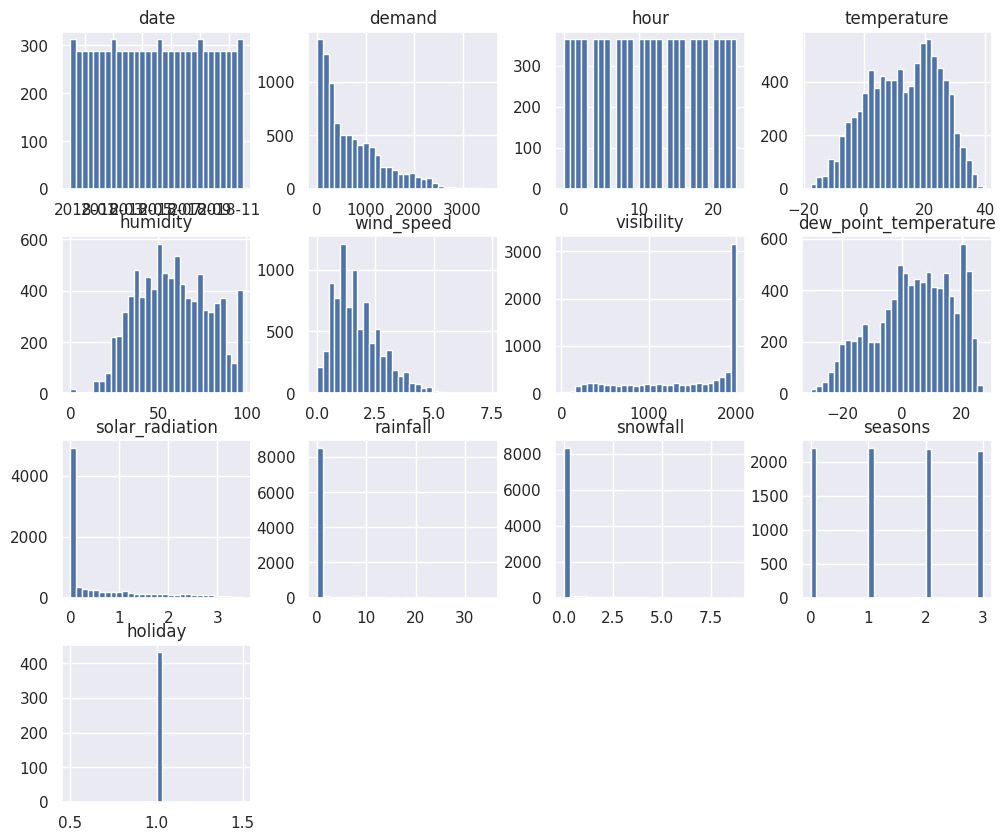

In [153]:
df_eda.hist(bins=30, figsize=(12, 10))
plt.show()

In [154]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8760 non-null   datetime64[ns]
 1   demand                 8760 non-null   int64         
 2   hour                   8760 non-null   int64         
 3   temperature            8760 non-null   float64       
 4   humidity               8760 non-null   int64         
 5   wind_speed             8760 non-null   float64       
 6   visibility             8760 non-null   int64         
 7   dew_point_temperature  8760 non-null   float64       
 8   solar_radiation        8760 non-null   float64       
 9   rainfall               8760 non-null   float64       
 10  snowfall               8760 non-null   float64       
 11  seasons                8760 non-null   int64         
 12  holiday                432 non-null    float64       
 13  fun

Correlations

In [155]:
df_eda.select_dtypes(include=np.number).corr()['demand']

demand                   1.000000
hour                     0.410257
temperature              0.538558
humidity                -0.199780
wind_speed               0.121108
visibility               0.199280
dew_point_temperature    0.379788
solar_radiation          0.261837
rainfall                -0.123074
snowfall                -0.141804
seasons                 -0.297095
holiday                       NaN
Name: demand, dtype: float64

Dates / Holidays / Seasons comparison

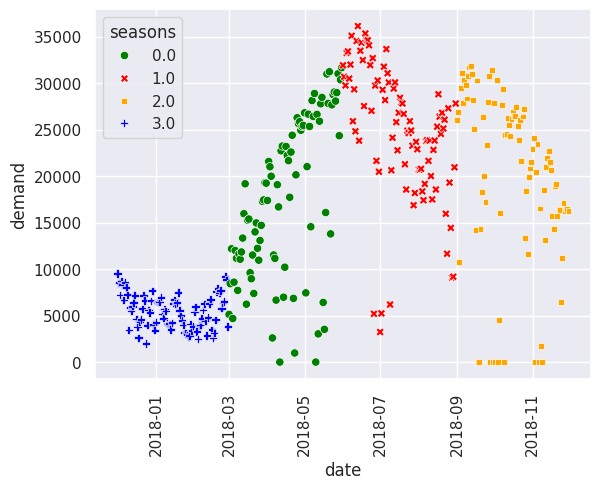

In [156]:
colors = {0:'green', 1:'red', 2:'orange',3:'blue'}
keys = ['date', 'demand', 'seasons', 'holiday']

_ = df_eda[keys].groupby(['date']).agg({'demand': 'sum', 'seasons': 'mean', 'holiday': 'mean'})

sns.scatterplot(data=_, x='date', y='demand', style='seasons', hue='seasons', palette=colors)
plt.xticks(rotation=90)
plt.show()


Demand by hour

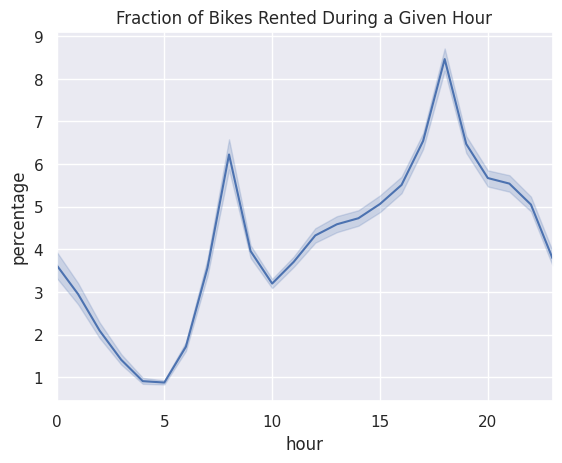

In [157]:
_ = df_eda[['date', 'hour', 'demand']].copy()

_['percentage'] = _.groupby('date')['demand'].transform(lambda x: 100*x / x.sum())

sns.lineplot(data=_, x='hour', y='percentage')
plt.title("Fraction of Bikes Rented During a Given Hour")
plt.xlim(0,23)
plt.show()

### Train-test split

In [158]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_labels = train_set['demand']
train_set = train_set.drop(columns=['demand'])

test_labels = test_set['demand']
test_set = test_set.drop(columns=['demand'])

### Model

1. Pipelines

In [159]:

def transform_date(df):
    df['date'] = (df['date'] - pd.to_datetime('2018-01-01')).apply(lambda x: x.days)
    return df


category_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
binary_category_pipeline = make_pipeline(OrdinalEncoder())

default_number_pipeline = make_pipeline(StandardScaler())
skewed_number_pipeline = make_pipeline(FunctionTransformer(np.sqrt, feature_names_out="one-to-one"), StandardScaler())
skewed_quantile_pipeline = make_pipeline(QuantileTransformer(output_distribution='normal', random_state=0))

date_pipeline = FunctionTransformer(transform_date, feature_names_out    ='one-to-one')

2. Transformation

In [160]:

preprocessing = ColumnTransformer([
    ("categorical", category_pipeline, ["seasons"]),
    ('date', date_pipeline, ['date']),
    ('number', default_number_pipeline, ['hour', 'temperature', 'humidity', 'visibility', 'solar_radiation', 'rainfall', 'snowfall', 'wind_speed']),
    ('drop', 'drop', ['holiday', 'functioning_day', 'dew_point_temperature']),
], remainder="passthrough")



3. Training models

In [161]:

random_forest = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
random_forest.fit(train_set, train_labels)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['seasons']),
                                                 ('date',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function transform_date at 0x7cace0d4f100>),
                                                  ['date']),
                                                 ('number',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['hour', 'temperature',
                                                   'humidity', 'visibility',
                                                   'solar_radiation',
                                                   'rainfall', 'snowfall',
                                                   'wind_speed']),
                                                 ('drop', 'drop',
                                                  ['holiday', 'functioning_day',
                                                   'dew_point_temperature'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Validation

In [162]:
forest_rmses = -cross_val_score(random_forest, train_set, train_labels, scoring="neg_root_mean_squared_error", cv=10)

In [163]:
pd.Series(forest_rmses).describe()

count     10.000000
mean     272.658757
std       20.046510
min      238.009920
25%      262.067757
50%      272.510512
75%      276.477670
max      305.081964
dtype: float64

### Fine tuning

In [166]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])

param_grid = [
    {'random_forest__max_features': [4, 6, 8]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(train_set, train_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['seasons']),
                                                                        ('date',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function transform_date at 0x7cace0d4f100>),
                                                                         ['date']),
                                                                        ('number',
                                                                         Pipe...aler',
                                                                                          StandardScaler())]),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'humidity',
                                                                          'visibility',
                                                                          'solar_radiation',
                                                                          'rainfall',
                                                                          'snowfall',
                                                                          'wind_speed']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['holiday',
                                                                          'functioning_day',
                                                                          'dew_point_temperature'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [167]:
grid_search.best_params_

{'random_forest__max_features': 8}

### Evaluation

In [ ]:
final_model = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42, max_features=8))
])
final_model.fit(train_set, train_labels)

final_predictions = final_model.predict(test_set)
final_rmse = root_mean_squared_error(test_labels, final_predictions)

final_rmse

265.5014875710762